# Projeto NLP - Detectando Fake News (Noticias falsas)
Neste notebook é feita a criação, treinamento e salvamento do modelo de Redes Neurais para detecção de Fake news.

# Motivação

No atual cenário de grande avanço tecnológico e uso das redes sociais em todas as camadas e classes sociais uma situação que causa problemas gráves é a divulgação de notícias falsas, pois essas podem prejucar a reputação de pessoas e organizações, e em casos mais gráves levar a linchamentos públicos.
Diante deste cenário, é de extrema importancia o desenvolvimento de métodos que consigam identificar possíveis noticias falsas para que seja possível tirá-las do ar.

Instalação das bibliotecas utilizadas

In [56]:
# !pip install -U scikit-learn
# !pip install pandas seaborn
# !pip install simpletransformers
# !pip install nltk
# !pip install tensorflow
# !pip install gensim
# !pip install pyyaml h5py

Importação das bibliotecas utilizaddas

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from datasets import load_dataset

from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
import re
import string
import numpy as np
import joblib

Configuração de display da biblioteca pandas

In [58]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.2f' %x)

# Lendo dados da base de dados 
<b>local de download:</b> Hugging faceFace

<b>url base 01:</b> https://huggingface.co/datasets/mrm8488/fake-news
<b>url base 02:</b> https://huggingface.co/datasets/fake_news_filipino

In [59]:
df_news = load_dataset("mrm8488/fake-news")
df_news = pd.DataFrame(df_news['train'])

df_news.head()

,text,label
0,The Trump administration has been getting abso...,1
1,NAIROBI (Reuters) - Kenyan police shot dead tw...,0
2,PC is killing our country. This is called figh...,1
3,WASHINGTON (Reuters) - Republicans are poised ...,0
4,(Reuters) - A U.S. appeals court ruled on Frid...,0


In [60]:
# Detalhes da base
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [61]:
# Colunas da base de dados
df_news.columns

Index(['text', 'label'], dtype='object')

In [62]:
# Validando a existência de dados nulos, no caso não existe
df_news.isnull().sum()

text     0
label    0
dtype: int64

In [63]:
# Validando a existência de dados na, no caso não existe
df_news.isna().sum()

text     0
label    0
dtype: int64

In [64]:
# Rótulos dos dados 0 - Notícia Real, 1 - Notícia falsa
df_news['label'].unique()

array([1, 0])

<Axes: xlabel='label', ylabel='count'>

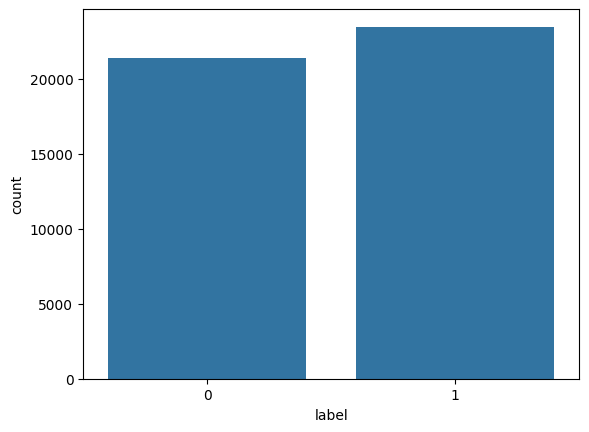

In [65]:
# Distribuição de positivos e negativos
sns.countplot(data=df_news, x='label')

Podemos observar que a base tem uma boa distribuição entre positivos e negativos, aproximadamente 50% para cada label.

# Preparando base para treinamento dos modelos
Separação em features e target

In [66]:
# Separando as features X e Y, treianemnto e teste
X = df_news['text']
Y = df_news['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=42)

# Tokenization
Criando uma representação para o texto por meio de p método TFiDF

In [67]:
# Download de stopwords para limpeza de ruidos
nltk.download('stopwords')
sw_en = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=sw_en, max_features=300)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/williansmagalhaesprimo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
# Aplicando a tokenização na base de treinamento
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()
X_train_tfidf.shape

(35918, 300)

# Redes Neurais - feedforward (Sequencial)
Nessa segunda abordagem, iremos utilizar uma Rede neural Sequencial

In [69]:
# Criando o modelo de Rede Neural
# Tamanho da entrada
input_size = X_train_tfidf.shape[1]
net = keras.Sequential()
net.add(layers.Dense(32, input_shape=(input_size,)))
net.add(layers.Dropout(.2))
net.add(layers.Dense(16, activation = 'tanh'))
net.add(layers.Dense(1, activation = 'sigmoid'))
print(net.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                9632      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10177 (39.75 KB)
Trainable params: 10177 (39.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [70]:
# Compilando o modelo de Rede Neural 
net.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)

In [71]:
# Treino do modelo
net.fit(X_train_tfidf, y_train, batch_size=16, epochs=2)

Epoch 1/2
2245/2245 [==============================] - 4s 1ms/step - loss: 0.0963 - accuracy: 0.9688
Epoch 2/2
2245/2245 [==============================] - 2s 999us/step - loss: 0.0388 - accuracy: 0.9879


In [72]:
# Aplicando a tokenização na base de teste
X_test_tfidf = vectorizer.transform(X_test).toarray()
X_test_tfidf.shape

(8980, 300)

In [73]:
# Teste do modelo Rede Neural
#prediction = net.evaluate(X_test_tfidf, y_test, batch_size = 1)
prediction = net.predict(X_test_tfidf)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

281/281 [==============================] - 0s 682us/step
Accuracy: 0.9900890868596882


In [74]:
# Métricas para o modelo Rede Neural (scores)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4271
           1       0.99      0.99      0.99      4709

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



<Axes: >

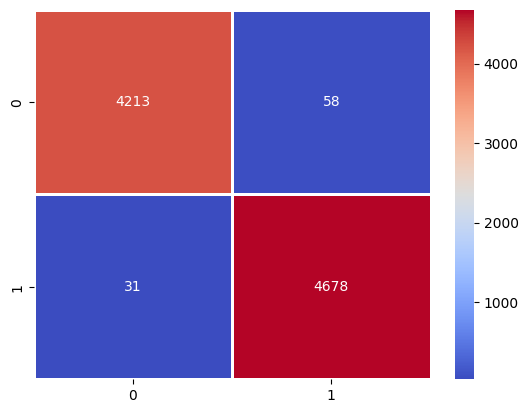

In [75]:
# Matriz de confusão
matriz_net = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(matriz_net, cmap='coolwarm', annot=True, linewidth=1, fmt='d')

Com a utilização de uma Rede Neural Feedfoward também observa-se um bom desempenho. Uma matriz de confusão equilibrada entre acertos, erros falsos positivos e falsos negativos.

### Salvando os modelos de Vetorização e Rede Neural

In [76]:
joblib.dump(vectorizer, 'modelo_rede_neural/1/model_vec.pkl')
tf.saved_model.save(net, 'modelo_rede_neural/1/model_net')

INFO:tensorflow:Assets written to: modelo_rede_neural/1/model_net/assets


INFO:tensorflow:Assets written to: modelo_rede_neural/1/model_net/assets
